# 1 準備

In [1]:
!nvidia-smi

Sat Jun 18 08:55:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# データ作成に使用するライブラリ
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# モデル作成に使用するライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# よく使用するライブラリ
import matplotlib.pyplot as plt
import numpy as np

# モデルの保存と読み込みするライブラリ
import pickle

torch.manual_seed(1)

In [3]:
batch_size = 100
n_channel = 100
n_epoch = 10
n_class = 10

In [4]:
# データ作成に使用するライブラリ
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

root = './data'
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
dataloader = DataLoader(mnist_train,batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# Google ドライブにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%cd '/content/gdrive/MyDrive/'

/content/gdrive/MyDrive


In [9]:
!mkdir './result'

mkdir: cannot create directory ‘./result’: File exists


# 2 モデル

In [10]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(n_channel+n_class, 512, 3, 1, 0),
                nn.BatchNorm2d(512),
                nn.ReLU()
            ), 
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(512, 256, 3, 2, 0),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(256, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            'layer3': nn.Sequential(
                nn.ConvTranspose2d(128, 1, 4, 2, 1),
                nn.Tanh()
            )
        })

    def forward(self, z):

        for layer in self.layers.values(): 
            z = layer(z)
        return z

In [11]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(1+n_class, 128, 4, 2, 1),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer1': nn.Sequential(
                nn.Conv2d(128, 256, 4, 2, 1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer2': nn.Sequential(
                nn.Conv2d(256, 512, 3, 2, 0),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer3': nn.Sequential(
                nn.Conv2d(512, 1, 3, 1, 0),
                nn.Sigmoid()
            )    
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x.squeeze()

In [12]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [13]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr = 0.0002, betas=(0.5, 0.999), weight_decay=1e-5) 
optimizerD = optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

# 3 条件指定用関数

In [14]:
def onehot_encode(label, device):
  
    eye = torch.eye(n_class, device=device)
    return eye[label].view(-1, n_class, 1, 1) 

In [15]:
def concat_image_label(image, label, device):

    B, C, H, W = image.shape
    
    oh_label = onehot_encode(label, device)
    oh_label = oh_label.expand(B, n_class, H, W)
    return torch.cat((image, oh_label), dim=1)

In [16]:
def concat_noise_label(noise, label, device):
  
    oh_label = onehot_encode(label, device)
    return torch.cat((noise, oh_label), dim=1)

# 4 モデルの学習

In [17]:
G_losses = []
D_losses = []
D_x_list = []
D_G_z1_list = []
D_G_z2_list = []

# 学習のループ
for epoch in range(n_epoch):

    for x, t in dataloader:

      # 前準備
      real_image = x.to(device) # 本物の画像データ
      noise = torch.randn(batch_size, n_channel, 1, 1, device=device)
      real_target = torch.full((batch_size,), 1., device=device) # 本物ラベル
      fake_target = torch.full((batch_size,), 0., device=device) # 偽物ラベル
      
      # discriminatorの学習(本物画像の学習)
      ############################################################
      real_label = t.to(device) # 本物の画像データ
      real_image_label = concat_image_label(real_image, real_label, device) 
      ############################################################
      discriminator.zero_grad() 
      y = discriminator(real_image_label)
      errD_real = criterion(y, real_target)
      D_x = y.mean().item()

      # discriminatorの学習(偽物画像の学習)
      ############################################################
      fake_label = torch.randint(10, (batch_size,), dtype=torch.long, device=device)
      fake_noise_label = concat_noise_label(noise, fake_label, device)
      fake_image = generator(fake_noise_label)
      fake_image_label = concat_image_label(fake_image, fake_label, device)   
      ############################################################
      y = discriminator(fake_image_label.detach())
      errD_fake = criterion(y, fake_target)
      D_G_z1 = y.mean().item()

      # discriminatorの更新
      errD = errD_real + errD_fake
      errD.backward()
      optimizerD.step()

      # generatorの学習
      generator.zero_grad()
      y = discriminator(fake_image_label)
      errG = criterion(y, real_target)
      errG.backward()
      D_G_z2 = y.mean().item()
      optimizerG.step()

      # 損失関数のリスト作成
      D_losses.append(errD.item())
      G_losses.append(errG.item())
      D_x_list.append(D_x)
      D_G_z1_list.append(D_G_z1)
      D_G_z1_list.append(D_G_z2)
      
    print('Epoch:{}/{}, Loss_D: {:.3f}, Loss_G: {:.3f}, D(x): {:.3f}, D(G(z)): {:.3f}/{:.3f}'
    .format(epoch + 1, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Epoch:1/10, Loss_D: 0.252, Loss_G: 2.706, D(x): 0.855, D(G(z)): 0.076/0.086
Epoch:2/10, Loss_D: 1.133, Loss_G: 1.030, D(x): 0.463, D(G(z)): 0.226/0.404
Epoch:3/10, Loss_D: 0.497, Loss_G: 1.668, D(x): 0.847, D(G(z)): 0.272/0.201
Epoch:4/10, Loss_D: 1.133, Loss_G: 1.197, D(x): 0.582, D(G(z)): 0.417/0.320
Epoch:5/10, Loss_D: 1.005, Loss_G: 1.193, D(x): 0.764, D(G(z)): 0.503/0.315
Epoch:6/10, Loss_D: 1.253, Loss_G: 0.910, D(x): 0.648, D(G(z)): 0.537/0.417
Epoch:7/10, Loss_D: 1.633, Loss_G: 0.672, D(x): 0.425, D(G(z)): 0.517/0.520
Epoch:8/10, Loss_D: 1.310, Loss_G: 0.933, D(x): 0.639, D(G(z)): 0.562/0.404
Epoch:9/10, Loss_D: 1.338, Loss_G: 0.865, D(x): 0.738, D(G(z)): 0.630/0.430
Epoch:10/10, Loss_D: 1.244, Loss_G: 1.137, D(x): 0.522, D(G(z)): 0.433/0.332


In [18]:
torch.save(generator.state_dict(), './result/generator.pth')

# 5 画像の生成

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


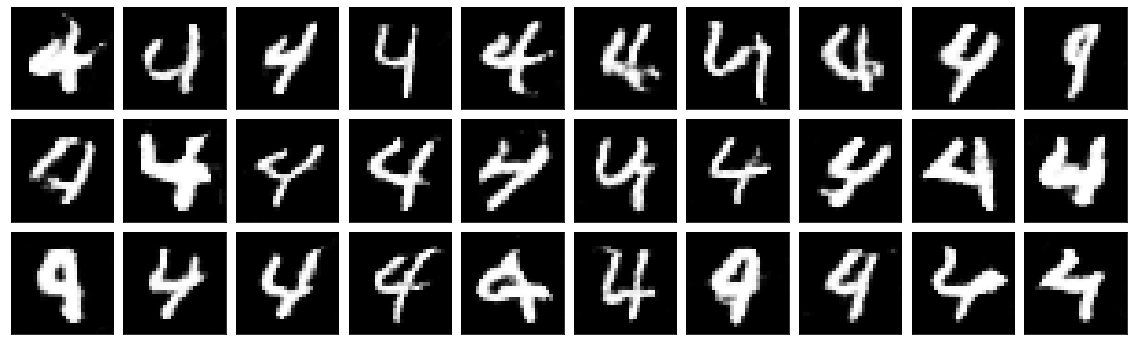

In [20]:
number = 4
n = 30
label_list = [number]*n

sample_noise = torch.randn(n, n_channel, 1, 1, device=device) 
sample_label = torch.tensor(label_list, dtype=torch.long, device=device)
sample_label = torch.tensor(sample_label, dtype=torch.long, device=device)
sample_noise_label = concat_noise_label(sample_noise, sample_label, device) 
generator.eval
y = generator(sample_noise_label)

# データの可視化
fig = plt.figure(figsize=(20, 8.5+2.*np.ceil(n/10)))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(n):
  if n < 10:
    ax = fig.add_subplot(1, n, i+1, xticks=[], yticks=[])
  else:
    ax = fig.add_subplot(np.ceil(n/10), 10, i+1, xticks=[], yticks=[])
  ax.imshow(y[i,].view(28,28).cpu().detach(), "gray")
plt.savefig("./result/generate_sample.png")